# Experiments with CIFAR10 Dataset and Attentive Gate MoE Training

The experiments in this notebook include training the attentive gate MoE models as follows:

1. attentive gate MoE without regularization.
2. attentive gate MoE with $L_{importance}$ regularization.
3. attentive gate MoE with $L_s$ regularization.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps

%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil, sin, cos, radians
from collections import OrderedDict
import os
import pandas as pd
from pprint import pprint
from copy import deepcopy
from itertools import product

In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")

else:
    device = torch.device("cpu")
print('device', device)

device cuda:0


In [5]:
# import MoE expectation model. All experiments for this dataset are done with the expectation model as it
# provides the best guarantee of interpretable task decompositions
from moe_models.moe_expectation_model import moe_expectation_model
from helper.moe_models import cross_entropy_loss
from helper.visualise_results import *

device cuda:0
device cuda:0
device cuda:0
device cuda:0


### NOTE: Pre-trained models are provided to check the results of all the experiments if you do not have the time to train all the models. 

In [6]:
# Paths to where the trained models and figures will be stored. You can change this as you see fit.
fig_path = '../figures'
model_path = '../models'
results_path = '../results'
pre_trained_model_path = '../models/pre_trained'

if not os.path.exists(fig_path):
    os.mkdir(fig_path)
if not os.path.exists(model_path):
    os.mkdir(model_path)
if not os.path.exists(results_path):
    os.mkdir(results_path)

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.49,0.48, 0.45), (0.25, 0.24, 0.26))]) #mean and standard deviation computed from the dataset

In [8]:
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
cifar10_testset, cifar10_trainset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.49, 0.48, 0.45), std=(0.25, 0.24, 0.26))
            ))

In [9]:
num_classes = 10

In [10]:
trainsize = 50000
testsize = 10000

In [11]:
batch_size = 128

In [12]:
cifar_trainloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar10_trainset, range(trainsize)), batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)
cifar_testloader = torch.utils.data.DataLoader(torch.utils.data.Subset(cifar10_testset, range(testsize)), batch_size=batch_size,
                                         shuffle=True, num_workers=4, pin_memory=True)

In [13]:
classes_cifar = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [14]:
#Function to display the images
def plot_colour_images(images_to_plot, titles=None, nrows=None, ncols=6, thefigsize=(18,18)):
    # images_to_plot: list of images to be displayed
    # titles: list of titles corresponding to the images
    # ncols: The number of images per row to display. The number of rows 
    #        is computed from the number of images to display and the ncols
    # theFigsize: The size of the layour of all the displayed images
    
    n_images = images_to_plot.shape[0]
    
    # Compute the number of rows
    if nrows is None:
        nrows = np.ceil(n_images/ncols).astype(int)
    
    fig,ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=thefigsize)
    ax = ax.flatten()
    
    for i in range(n_images):
        img = images_to_plot[i,:,:,:]
        npimg = np.clip(img.numpy(),0,1)
        ax[i].imshow(npimg) 
        ax[i].axis('off')  
        if titles is not None and i<10:
            ax[i].set_title(titles[i%10])

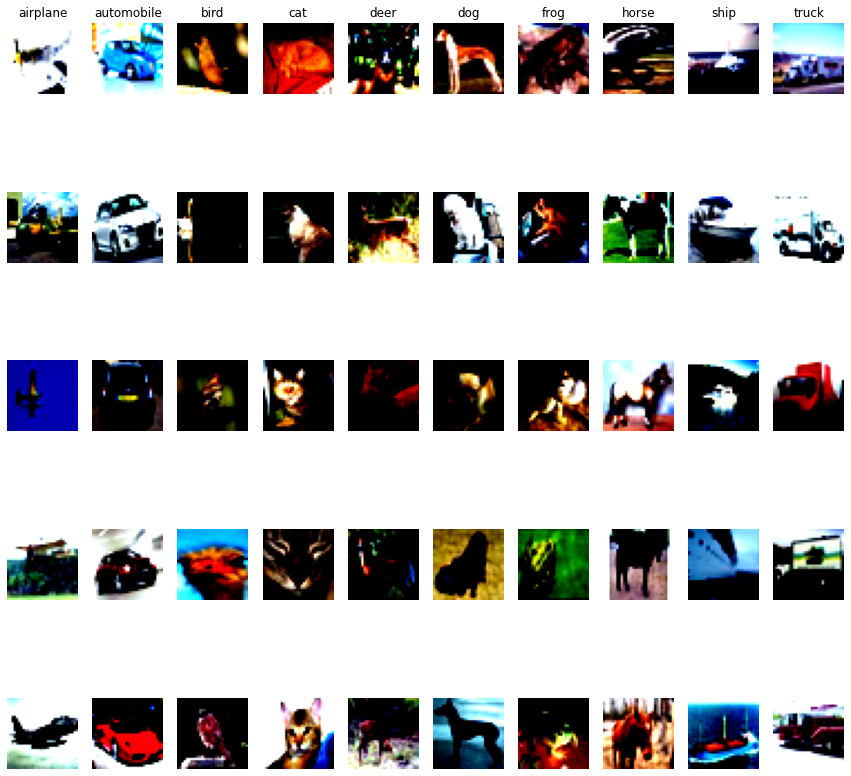

In [15]:
# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = dataiter.next()


images_to_plot = []
for i in range(0, len(classes_cifar)):
    # pick images of each class
    index = np.where(labels==i)[0]
    
    if i == 0:
        images_to_plot.append(images[index[0:5],:,:])
    else:
        images_to_plot.append(images[index[0:5],:,:])

images_to_plot = torch.transpose(torch.stack(images_to_plot),0,1)
new_shape = images_to_plot.shape
images_to_plot = images_to_plot.reshape(new_shape[0]*new_shape[1], new_shape[2], new_shape[3], new_shape[4])
images_to_plot = images_to_plot.permute(0,2,3,1)

plot_colour_images(images_to_plot, nrows=5, ncols=10,thefigsize=(15,15), titles=classes_cifar)
    


## Define expert and gate networks

In [16]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class expert_layers(nn.Module):
    def __init__(self, num_classes):
        super(expert_layers, self).__init__()
        filter_size = 3
        self.filters = 3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.fc1 = nn.Linear(self.filters*4*2*2,64)
        self.fc2 = nn.Linear(64,32)
        
        self.out = nn.Linear(in_features=32, out_features=num_classes)
                
    def forward(self, x):
        # conv 1
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn4(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*4*2*2)
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
                      
        self.hidden = x
            
        x = F.relu(x)
                
        # output
        x = F.softmax(self.out(x), dim=1)
        
        return x

In [17]:
# Convolutional network with one convolutional layer and 2 hidden layers with ReLU activation
class gate_attn_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_attn_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.fc1 = nn.Linear(self.filters*4*2*2, 512)
        self.fc2 = nn.Linear(512, 32)
                
    def forward(self, x, T=1.0, y=None):
        # conv 1
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn4(self.conv4(x))))

        x = x.reshape(-1, self.filters*4*2*2)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


In [18]:
# Convolutional network with one convultional layer and 2 hidden layers with ReLU activation
class gate_layers(nn.Module):
    def __init__(self, num_experts):
        super(gate_layers, self).__init__()
        # define layers
        filter_size = 3
        self.filters = 64
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.filters, kernel_size=filter_size, padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.filters, out_channels=self.filters*2, kernel_size=filter_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.filters*2)
        self.mp = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Conv2d(in_channels= self.filters*2, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.filters*4, out_channels=self.filters*4, kernel_size=filter_size, stride=1, padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(self.filters*4)

        self.fc1 = nn.Linear(self.filters*4*2*2, 512)
        self.fc2 = nn.Linear(512, 32)
        
        self.out = nn.Linear(in_features=32, out_features=num_experts)
        
    def forward(self, x, T=1.0, y=None):
        # conv 1        
        x = self.mp(F.relu(self.conv1(x)))
        x = self.mp(F.relu(self.bn2(self.conv2(x))))

        x = self.mp(F.relu(self.conv3(x)))
        x = self.mp(F.relu(self.bn4(self.conv4(x))))
        
        x = x.reshape(-1, self.filters*4*2*2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.out(x)
        x = F.softmax(x/T, dim=1)
        return x


In [19]:
# create a set of experts
def experts(num_experts, num_classes, expert_layers_type=expert_layers):
    models = []
    for i in range(num_experts):
        models.append(expert_layers_type(num_classes))
    return nn.ModuleList(models)

## Initialize configurations and helper functions

In [20]:
# Compute accuracy of the model
def accuracy(out, yb, mean=True):
    preds = torch.argmax(out, dim=1).to(device, non_blocking=True)
    if mean:
        return (preds == yb).float().mean()
    else:
        return (preds == yb).float()

## Functions to train models

### Function to train attentive gate model with and without regularization

* w_importance_range is the range of values for the $w_{importance}$ hyperparameter of the $L_{importance}$ regularization.
* w_sample_sim_same_range is the range of values for $\beta_s$ hyperparameter of the $L_s$ regularization.
* w_sample_sim_diff_range is the range of values for $\beta_d$ hyperparameter of the $L_s$ regularization.

In [21]:
def train_with_attention(model_1, trainloader, testloader, runs, temps=[[1.0]*20], 
                         w_importance_range=[0.0], w_sample_sim_same_range=[0.0], 
                         w_sample_sim_diff_range=[0.0], 
                         num_classes=10, total_experts=5, num_epochs=20):
    
    hidden = 32
    
    for T, w_importance, w_sample_sim_same, w_sample_sim_diff in product(temps, w_importance_range, w_sample_sim_same_range,  
                                                                         w_sample_sim_diff_range):                                                                       
        
        print('w_importance','{:.1f}'.format(w_importance))
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        for run in range(1, runs+1):

            print('Run:', run)
            
            n_run_models_1 = []
            
            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                               'experts':{}},}
            for key, val in models.items():

                expert_models = experts(total_experts, num_classes).to(device)
                
                gate_model = gate_attn_layers(total_experts).to(device)

                moe_model = val['model'](total_experts, num_classes, attention_flag=1, hidden=hidden, 
                                         experts=expert_models, gate=gate_model).to(device)
                
                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)
                

                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, w_importance=w_importance, 
                                       w_sample_sim_same = w_sample_sim_same, w_sample_sim_diff = w_sample_sim_diff, 
                                       accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            # Save all the trained models
            plot_file = generate_plot_file(model_1, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
            
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
            n_run_models_1.append(models)
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            

### Function to distill the attentive gate model to the original model

In [22]:
def train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=[0.0], 
                     w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                     trainloader=None, testloader=None, expert_no_grad=True, gate_no_grad=False):
    
    T = [1.0]*num_epochs
    for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
        
        print('w_importance','{:.1f}'.format(w_importance))
        
        if w_sample_sim_same < 1:
            print('w_sample_sim_same',str(w_sample_sim_same))
        else:
            print('w_sample_sim_same','{:.1f}'.format(w_sample_sim_same))
        
        if w_sample_sim_diff < 1:
            print('w_sample_sim_diff',str(w_sample_sim_diff))
        else:
            print('w_sample_sim_diff','{:.1f}'.format(w_sample_sim_diff))
        
        plot_file = generate_plot_file(m, temp=T[0], w_importance=w_importance,  
                                       w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                       specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

        attn_models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)

        n_run_models_1 = []
        for model in attn_models: 
            # Initialise the new expert weights to the weights of the experts of the trained attentive gate model.
            # Fix all the weights of the new experts so they are not trained. 

            new_expert_models = experts(total_experts, num_classes).to(device)
            old_expert_models = model['moe_expectation_model']['experts'][total_experts]['model'].experts
            for i, expert in enumerate(new_expert_models):
                old_expert = old_expert_models[i]
                expert.load_state_dict(old_expert.state_dict())
                if expert_no_grad:
                    for param in expert.parameters():
                        param.requires_grad = False

            new_gate_model = gate_layers(total_experts).to(device)
            old_gate_model = model['moe_expectation_model']['experts'][total_experts]['model'].gate
            new_gate_model.load_state_dict(old_gate_model.state_dict(), strict=False)

            if gate_no_grad:
                for param in new_gate_model.parameters():
                    param.requires_grad = False
                new_gate_model.out = nn.Linear(in_features=32, out_features=num_experts)
                
            gate_model = new_gate_model

            models = {'moe_expectation_model':{'model':moe_expectation_model,'loss':cross_entropy_loss(),
                                           'experts':{}},}

            for key, val in models.items():

                # gate_model = gate_layers(total_experts).to(device)                

                moe_model = val['model'](total_experts, num_classes,
                                         experts=new_expert_models, gate= gate_model).to(device)

                optimizer_moe = optim.Adam(moe_model.parameters(), lr=0.001, amsgrad=False)


                hist = moe_model.train(trainloader, testloader,  val['loss'], optimizer_moe = optimizer_moe,
                                       T = T, accuracy=accuracy, epochs=num_epochs)
                val['experts'][total_experts] = {'model':moe_model, 'history':hist}

            plot_file = generate_plot_file('new_'+m, T[0], w_importance=w_importance, w_sample_sim_same=w_sample_sim_same,w_sample_sim_diff=w_sample_sim_diff,
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')
        
            if os.path.exists(os.path.join(model_path, plot_file)):
                n_run_models_1 = torch.load(open(os.path.join(model_path, plot_file),'rb'))
                
            n_run_models_1.append(models)                                
            torch.save(n_run_models_1,open(os.path.join(model_path, plot_file),'wb'))
            n_run_models_1 = []
            print(plot_file)        


## Experiments

### Experiment 1: Attentive gate MoE model training

In [23]:
# Model with gate and expert parameters initialized to default values
model_1 = 'cifar_with_attention'

In [24]:
total_experts = 5

In [25]:
num_epochs = 20

In [26]:
runs = 10

In [27]:
train_with_attention(model_1, cifar_trainloader, cifar_testloader, runs, num_classes=num_classes, 
                     total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
epoch 0 training loss 1.58 , training accuracy 0.41 , test accuracy 0.50
epoch 1 training loss 1.21 , training accuracy 0.57 , test accuracy 0.57
epoch 2 training loss 1.05 , training accuracy 0.64 , test accuracy 0.62
epoch 3 training loss 0.93 , training accuracy 0.68 , test accuracy 0.66
epoch 4 training loss 0.82 , training accuracy 0.72 , test accuracy 0.67
epoch 5 training loss 0.73 , training accuracy 0.75 , test accuracy 0.69
epoch 6 training loss 0.66 , training accuracy 0.78 , test accuracy 0.69
epoch 7 training loss 0.59 , training accuracy 0.80 , test accuracy 0.70
epoch 8 training loss 0.54 , training accuracy 0.82 , test accuracy 0.71
epoch 9 training loss 0.49 , training accuracy 0.84 , test accuracy 0.71
epoch 10 training loss 0.46 , training accuracy 0.85 , test accuracy 0.72
epoch 11 training loss 0.43 , training accuracy 0.86 , test accuracy 0.71
epoch 12 training loss 0.40 , training accuracy 0.86 ,

### Experiment 2: Attentive gate MoE model training with $L_{importance}$ regularization

In [29]:
# Model with gate and expert parameters initialized to default values
model_2 = 'cifar_with_attn_reg'

In [30]:
total_experts = 5

In [31]:
num_epochs = 20

In [32]:
w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']


In [33]:
runs = 10

In [34]:
train_with_attention(model_2, cifar_trainloader, cifar_testloader, runs, w_importance_range=w_importance_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
Run: 1
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(5.0433e-05, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0033, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0305, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0005, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0025, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0030, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0013, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0006, device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([128, 3, 32, 32]) 0.0 0.0
l_imp_reg tensor(0.0001, device='cuda:0', grad_fn=<MulBackward0>)
t

KeyboardInterrupt: 

### Experiment 3: Attentive gate MoE model training with sample similarity $L_s$ regularization

In [76]:
# Model with gate and expert parameters initialized to default values
model_3 = 'cifar_with_attn_reg'

In [77]:
total_experts = 5

In [78]:
num_epochs = 20

In [79]:
w_sample_sim_same_range = [1e-7,1e-6,1e-5]
w_sample_sim_same_range = [1e-3]
w_sample_sim_diff_range = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

w_sample_sim_same_range =  [0.001]
w_sample_sim_diff_range =  [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


In [80]:
runs = 10

In [ ]:
train_with_attention(model_3, cifar_trainloader, cifar_testloader, runs,
                     w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, 
                     num_classes=num_classes, total_experts=total_experts, num_epochs=num_epochs)

w_importance 0.0
w_sample_sim_same 0.001
w_sample_sim_diff 1e-07
Run: 1
epoch 0 training loss 1.92 , training accuracy 0.42 , test accuracy 0.51
epoch 1 training loss 1.49 , training accuracy 0.57 , test accuracy 0.59
epoch 2 training loss 1.31 , training accuracy 0.65 , test accuracy 0.64
epoch 3 training loss 1.19 , training accuracy 0.69 , test accuracy 0.66
epoch 4 training loss 1.09 , training accuracy 0.73 , test accuracy 0.68
epoch 5 training loss 1.00 , training accuracy 0.76 , test accuracy 0.70
epoch 6 training loss 0.94 , training accuracy 0.78 , test accuracy 0.70
epoch 7 training loss 0.87 , training accuracy 0.81 , test accuracy 0.70
epoch 8 training loss 0.82 , training accuracy 0.82 , test accuracy 0.71
epoch 9 training loss 0.77 , training accuracy 0.84 , test accuracy 0.72
epoch 10 training loss 0.73 , training accuracy 0.85 , test accuracy 0.72
epoch 11 training loss 0.70 , training accuracy 0.86 , test accuracy 0.72
epoch 12 training loss 0.68 , training accuracy 0.

### Experiment 4: Distilling attentive gate MoE model

#### Distilling attentive gate MoE model with $L_{importance}$ regularization

In [49]:
m = 'cifar_with_attn_reg'

total_experts = 5
num_classes = 10
num_epochs = 20

w_importance_range = [i * 0.2 for i in range(1, 6)]
print('w_importance_range = ', ['{:.1f}'.format(w) for w in w_importance_range])

train_from_model(m, num_epochs, num_classes, total_experts, w_importance_range=w_importance_range, trainloader=cifar_trainloader, testloader=cifar_testloader)

w_importance_range =  ['0.2', '0.4', '0.6', '0.8', '1.0']
w_importance 0.2
w_sample_sim_same 0.0
w_sample_sim_diff 0.0
epoch 0 training loss 0.32 , training accuracy 0.90 , test accuracy 0.72
epoch 1 training loss 0.25 , training accuracy 0.91 , test accuracy 0.72
epoch 2 training loss 0.24 , training accuracy 0.91 , test accuracy 0.72
epoch 3 training loss 0.25 , training accuracy 0.91 , test accuracy 0.73
epoch 4 training loss 0.24 , training accuracy 0.91 , test accuracy 0.72
epoch 5 training loss 0.24 , training accuracy 0.91 , test accuracy 0.73
epoch 6 training loss 0.24 , training accuracy 0.91 , test accuracy 0.73
epoch 7 training loss 0.24 , training accuracy 0.91 , test accuracy 0.72
epoch 8 training loss 0.23 , training accuracy 0.91 , test accuracy 0.73
epoch 9 training loss 0.24 , training accuracy 0.91 , test accuracy 0.72
epoch 10 training loss 0.24 , training accuracy 0.91 , test accuracy 0.72
epoch 11 training loss 0.23 , training accuracy 0.91 , test accuracy 0.72
epo

#### Distilling attentive gate MoE model with $L_{s}$ regularization

In [38]:
m = 'cifar_with_attn_reg'

total_experts = 5
num_classes = 10
num_epochs = 20

w_sample_sim_same_range = [1e-7,1e-6,1e-5]
w_sample_sim_same_range = [1e-4]
w_sample_sim_diff_range = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
print('w_sample_sim_same_range = ', w_sample_sim_same_range)
print('w_sample_sim_diff_range = ', w_sample_sim_diff_range)

train_from_model(m, num_epochs, num_classes, total_experts, w_sample_sim_same_range=w_sample_sim_same_range,
                 w_sample_sim_diff_range=w_sample_sim_diff_range,
                 trainloader=cifar_trainloader, testloader=cifar_testloader)

w_sample_sim_same_range =  [0.0001]
w_sample_sim_diff_range =  [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]
w_importance 0.0
w_sample_sim_same 0.0001
w_sample_sim_diff 1e-07


FileNotFoundError: [Errno 2] No such file or directory: '../models/cifar_with_attn_reg_sample_sim_same_0.0001_sample_sim_diff_1e-07_10_5_models.pt'

## Results

### Collect the train error, test error, mutual information $I(E;Y)$, sample entropy $H_s$ and expert usage entropy $H_u$ for all the models trained with CIFAR10 dataset. Store the reuslts in the '../results/fmnist_results.csv' file.

In [29]:
import csv
from helper import moe_models

def collect_results(m, temps=[1.0], w_importance_range=[0.0], 
                    w_sample_sim_same_range=[0.0], w_sample_sim_diff_range=[0.0],
                    total_experts=5, num_classes=10, num_epochs=20, 
                    testloader=None, model_path=None, results_path=None, filename = 'cifar_results.csv'):
    
    filename = os.path.join(results_path, filename)
    
    if os.path.exists(filename):
        p = 'a'
    else:
        p = 'w'
        
    header = ['filename', 'train error', 'test error','mutual information', 'sample entropy', 'experts usage']
    
    with open(filename, p) as f:
                
        writer = csv.writer(f)        
        
        if p == 'w':            
            writer.writerow(header)
        
        for w_importance, w_sample_sim_same, w_sample_sim_diff in product(w_importance_range, w_sample_sim_same_range, w_sample_sim_diff_range):
            plot_file = generate_plot_file(m, w_importance=w_importance, w_sample_sim_same=w_sample_sim_same, w_sample_sim_diff=w_sample_sim_diff, 
                                           specific=str(num_classes)+'_'+str(total_experts)+'_models.pt')

            models = torch.load(open(os.path.join(model_path, plot_file),'rb'), map_location=device)
            for _ in range(len(models)):
                mod = models.pop()
                data = [plot_file]
                # model
                model = mod['moe_expectation_model']['experts'][total_experts]['model']
                # history
                history = mod['moe_expectation_model']['experts'][total_experts]['history']
                # train error
                data.append(1-history['accuracy'][-1].item())
                running_test_accuracy = 0.0
                running_entropy = 0.0
                num_batches = 0
                ey =  torch.zeros((num_classes, total_experts)).to(device)
                for test_inputs, test_labels in testloader:
                    test_inputs, test_labels = test_inputs.to(device, non_blocking=True), test_labels.to(device, non_blocking=True)                
                    outputs = model(test_inputs)
                    running_test_accuracy += accuracy(outputs, test_labels)
                    
                    selected_experts = torch.argmax(model.gate_outputs, dim=1)
                    y = test_labels
                    e = selected_experts
                    for j in range(y.shape[0]):
                        ey[int(torch.argmax(model.expert_outputs[j,e[j],:])), int(e[j])] += 1

                    running_entropy += moe_models.entropy(model.gate_outputs)
                    
                    num_batches+=1
 
                mutual_EY,_,_,_ = moe_models.mutual_information(ey.detach())
    
                test_error = 1-(running_test_accuracy/num_batches)
                data.append(test_error.item())
                data.append(mutual_EY.item())
                
                data.append(running_entropy.item()/num_batches)  
                gate_probabilities_sum = torch.mean(model.gate_outputs, dim=0)            
                data.append(entropy(gate_probabilities_sum).item())
                
                writer.writerow(data)
            
            

In [54]:
total_experts = 5
num_classes = 10
num_epochs = 20

In [108]:
model_path = os.path.join(pre_trained_model_path,'cifar10')
results_path = os.path.join(results_path,'test')

In [55]:
m = 'cifar_without_reg'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [56]:
m = 'cifar_with_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [68]:
m = 'cifar_with_reg'
w_sample_sim_same_range = [1e-7, 1e-6, 1e-5]
w_sample_sim_same_range = [1e-3]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [56]:
m = 'cifar_with_attention'
collect_results(m, total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [57]:
m = 'cifar_with_attn_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [45]:
m = 'cifar_with_attn_reg'
w_sample_sim_same_range = [1e-7, 1e-6,1e-5]
w_sample_sim_same_range = [1e-3]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [59]:
m = 'new_cifar_with_attn_reg'
w_importance_range = [i * 0.2 for i in range(1, 6)]
collect_results(m, w_importance_range=w_importance_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

In [29]:
m = 'new_cifar_with_attn_reg'
w_sample_sim_same_range = [1e-7, 1e-6,1e-5]
w_sample_sim_same_range = [1e-4]
w_sample_sim_diff_range = [1e-7, 1e-6, 1e-5,1e-4,1e-3,1e-2,1e-1]
w_sample_sim_diff_range = [1e-4,1e-3,1e-2,1e-1]
collect_results(m, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range,
                total_experts=total_experts, num_classes=num_classes, num_epochs=num_epochs, 
                testloader=cifar_testloader, model_path=model_path, results_path=results_path)

NameError: name 'collect_results' is not defined

### Final results

#### These are the final performance results, reported in the paper, on the test data for the model with the minimum training error for each category of MoE model and training method.

In [69]:
import pandas as pd
filename = os.path.join(results_path, 'cifar_results.csv')
data = pd.read_csv(filename)

In [70]:
final_results_filename = os.path.join(results_path,'cifar_final_results.csv')

In [71]:
models = [ 'cifar_single_model', 'cifar_without_reg', 'cifar_with_reg_importance', 
          'cifar_with_reg_sample', 'cifar_with_attention', 'cifar_with_attn_reg_importance',
          'cifar_with_attn_reg_sample', 'new_cifar_with_attn_reg_importance',
          'new_cifar_with_attn_reg_sample'] #'cifar_single_model',
header = True
for i, m in enumerate(models):
    model_data = data[data['filename'].str.startswith(m)]
    if model_data.empty:
        continue
    if i:
        header = False
    row = data.loc[[data[data['filename'].str.startswith(m)]['train error'].idxmin()]]
#     row = data.loc[[data[data['filename'].str.startswith(m)]['test error'].idxmin()]]
#     row = data.loc[[data[data['filename'].str.startswith(m)]['sample entropy'].idxmin()]]
#     row = data.loc[[data[data['filename'].str.startswith(m)]['experts usage'].idxmax()]]
    std = '{:.3f}'.format(data[data['filename'].str.startswith(m)]['test error'].std())
    row['val error std'] = std
    row.to_csv(final_results_filename,mode='a',header=header, index=False, float_format='%.3f')

In [72]:
data = pd.read_csv(final_results_filename)
data.fillna('NA', inplace=True)
data

,filename,train error,test error,mutual information,sample entropy,experts usage,val error std
0,cifar_single_model_6,0.378,0.404,NA,NA,NA,0.008
1,cifar_without_reg_10_5_models.pt,0.114,0.276,2.318,0.277,2.061,0.025
2,cifar_with_reg_importance_0.2_10_5_models.pt,0.061,0.254,2.313,0.401,2.215,0.022
3,cifar_with_reg_sample_sim_same_0.001_sample_si...,0.065,0.248,2.311,0.429,2.288,0.024
4,cifar_with_attention_10_5_models.pt,0.091,0.279,2.197,0.17,2.114,0.011
5,cifar_with_attn_reg_importance_0.6_10_5_models.pt,0.057,0.261,2.254,0.198,2.087,0.011
6,cifar_with_attn_reg_sample_sim_same_0.0001_sam...,0.070,0.263,2.208,0.203,2.132,0.009
7,new_cifar_with_attn_reg_importance_0.6_10_5_mo...,0.054,0.263,2.272,0.145,2.018,0.011
8,new_cifar_with_attn_reg_sample_sim_same_1e-05_...,0.067,0.265,2.195,0.146,2.031,0.011


In [31]:
data = pd.read_csv(os.path.join(results_path,final_results_filename))
data.fillna('NA', inplace=True)
data

,filename,train error,test error,mutual information,sample entropy,experts usage,val error std
0,cifar_single_model_2,0.323,0.368,NA,NA,NA,0.009
1,cifar_without_reg_10_5_models.pt,0.116,0.276,2.174,0.337,2.118,0.025
2,cifar_with_reg_importance_0.2_10_5_models.pt,0.107,0.254,2.322,0.376,2.171,0.025
3,cifar_with_reg_sample_sim_same_1e-07_sample_si...,0.088,0.264,2.21,0.381,2.121,0.019
4,cifar_with_attention_10_5_models.pt,0.094,0.282,2.076,0.178,2.231,0.032
5,cifar_with_attn_reg_importance_0.8_10_5_models.pt,0.051,0.238,2.295,0.217,2.007,0.014
6,cifar_with_attn_reg_sample_sim_same_1e-06_samp...,0.069,0.267,2.095,0.21,2.166,0.033
7,new_cifar_with_attn_reg_importance_0.8_10_5_mo...,0.043,0.239,2.295,0.135,1.93,0.014
8,new_cifar_with_attn_reg_sample_sim_same_1e-06_...,0.057,0.267,2.066,0.136,1.793,0.032


Min Training Error 0.114
Mutual Information 2.322
Sample Entropy 0.175
Expert Usage 2.322
cifar_without_reg_10_5_models.pt


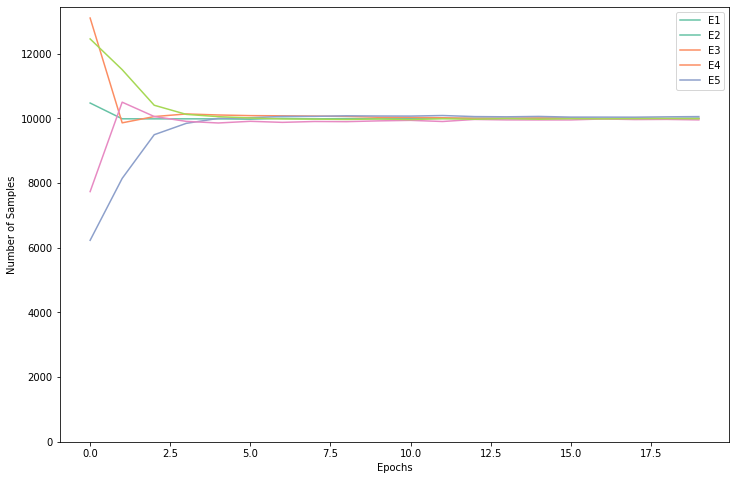

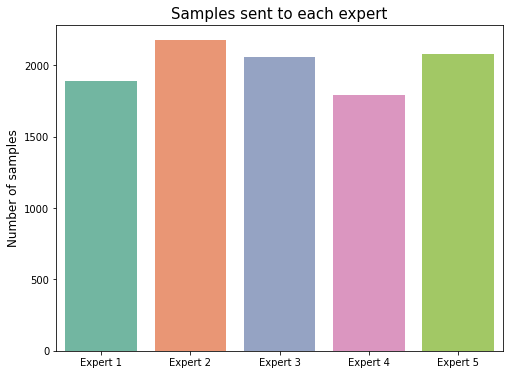

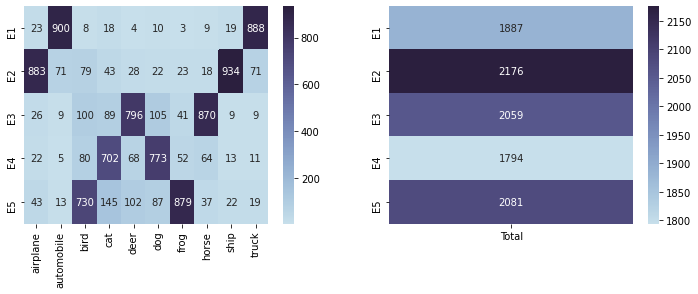


Experts used by the gate for classification of each digit


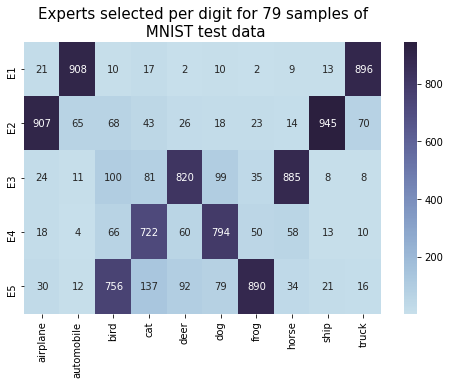

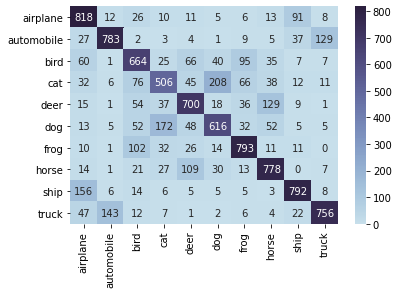

In [67]:
m = 'cifar_without_reg'
total_experts = 5
num_classes = 10
classes = classes_cifar
num_epochs = 20

w_importance_range = [0.0]                           

test_loader = cifar_testloader

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.085
Mutual Information 2.322
Sample Entropy 0.358
Expert Usage 2.322
cifar_with_reg_importance_1.0_10_5_models.pt


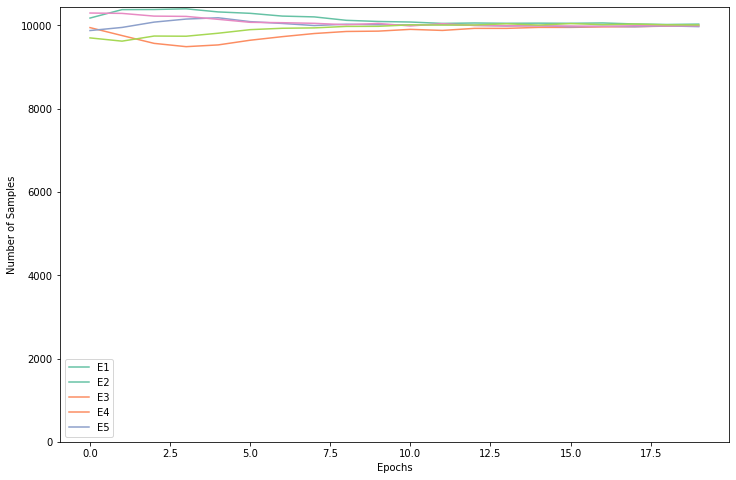

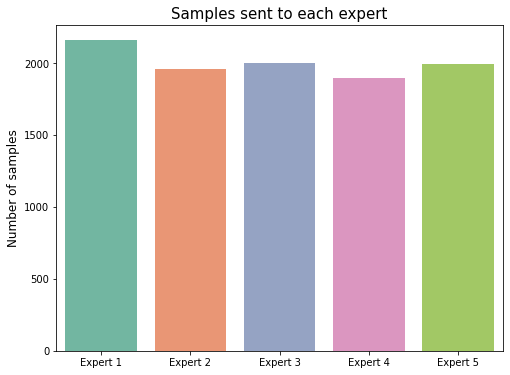

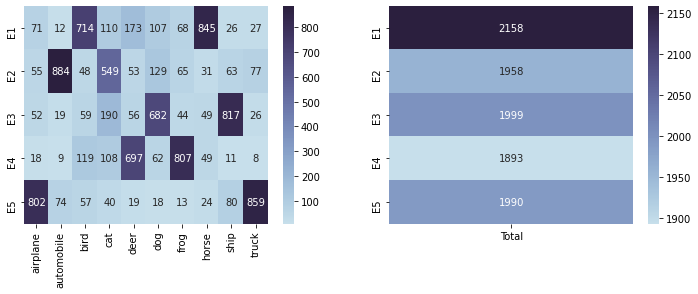


Experts used by the gate for classification of each digit


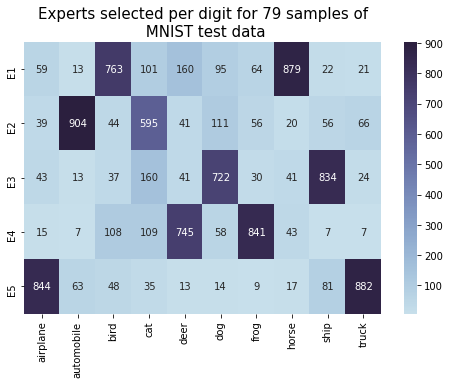

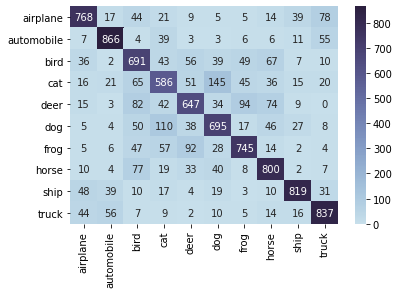

In [45]:
m = 'cifar_with_reg'
total_experts = 5
num_classes = 10
classes = classes_cifar
num_epochs = 20

w_importance_range = [1.0]                           

test_loader = cifar_testloader

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.065
Mutual Information 2.313
Sample Entropy 0.284
Expert Usage 2.322
cifar_with_reg_sample_sim_same_0.001_sample_sim_diff_1e-07_10_5_models.pt


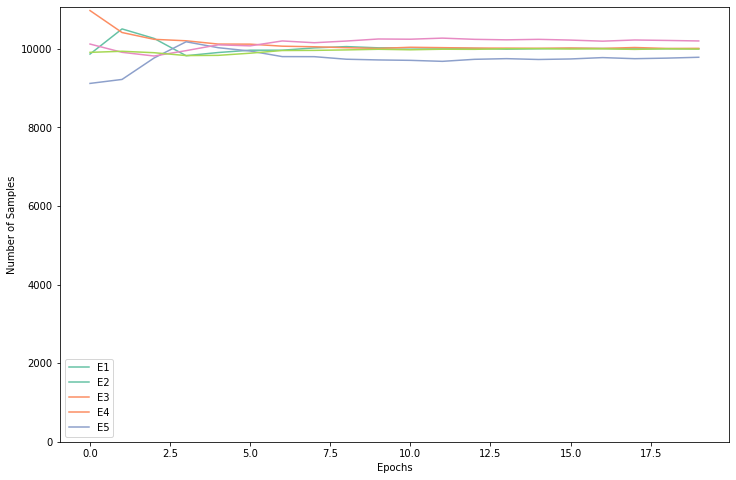

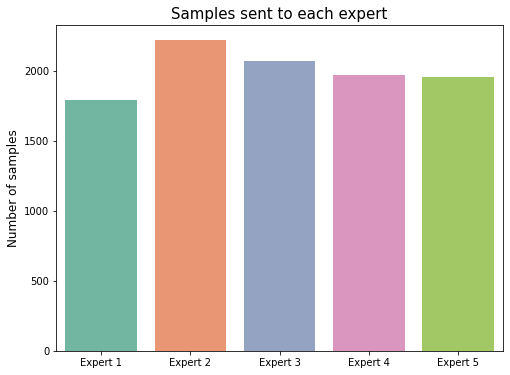

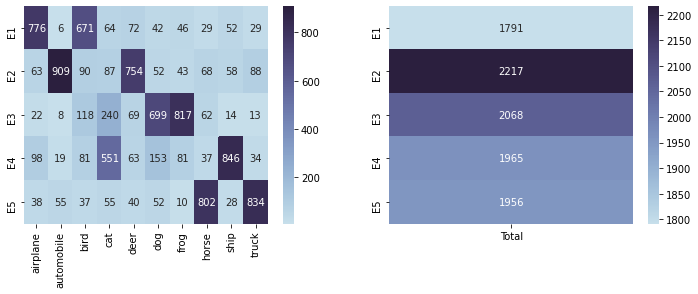


Experts used by the gate for classification of each digit


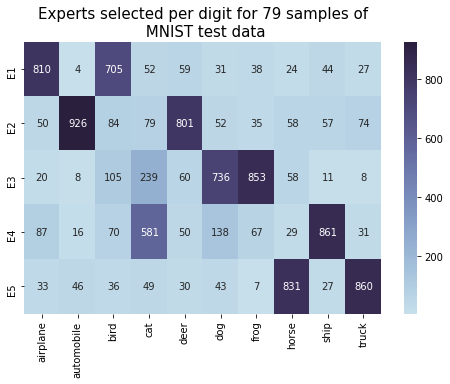

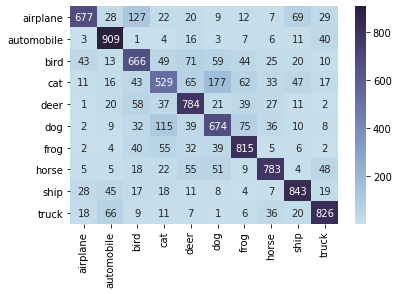

In [75]:
m = 'cifar_with_reg'
total_experts = 5
num_classes = 10
classes = classes_cifar
num_epochs = 20

w_sample_sim_same_range = [1e-3]
w_sample_sim_diff_range = [1e-7]
                           
test_loader = cifar_testloader

plot_expert_usage(m, test_loader, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, total_experts=total_experts,num_classes=num_classes,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

Min Training Error 0.091
Mutual Information 2.203
Sample Entropy 0.048
Expert Usage 2.251
cifar_with_attention_10_5_models.pt


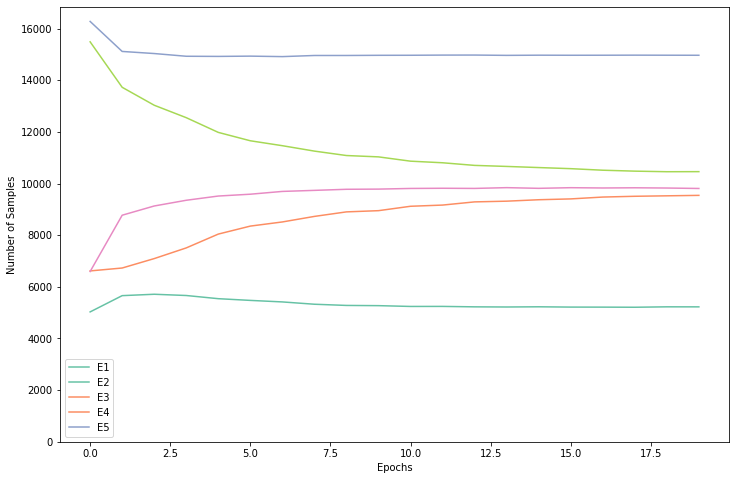

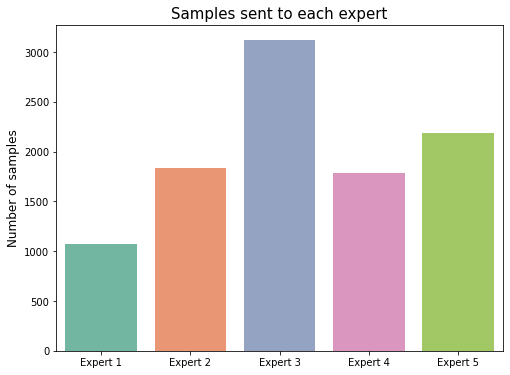

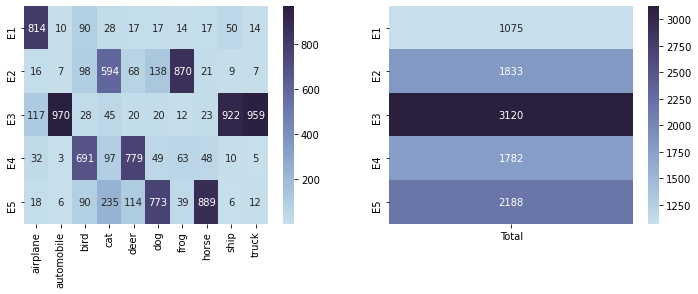


Experts used by the gate for classification of each digit


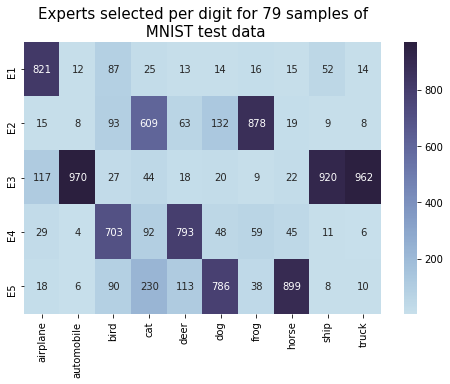

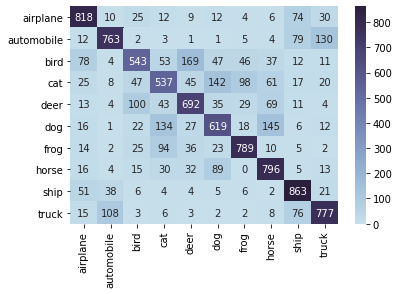

In [66]:
m = 'cifar_with_attention'
total_experts = 5
num_classes = 10
classes = classes_cifar
num_epochs = 20

w_importance_range = [0.0]                           

test_loader = cifar_testloader

plot_expert_usage(m, test_loader, w_importance_range=w_importance_range,
                  total_experts=total_experts,num_classes=num_classes,
                 classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

In [74]:
m = 'cifar_with_attn_reg'
total_experts = 5
num_classes = 10
classes = classes_cifar
num_epochs = 20

w_sample_sim_same_range = [1e-3]
w_sample_sim_diff_range = [1e-7]
                           
test_loader = cifar_testloader

plot_expert_usage(m, test_loader, w_sample_sim_same_range=w_sample_sim_same_range, w_sample_sim_diff_range=w_sample_sim_diff_range, total_experts=total_experts,num_classes=num_classes,
                        classes=classes, num_epochs=num_epochs, fig_path=fig_path, model_path=model_path)

FileNotFoundError: [Errno 2] No such file or directory: '../models/cifar_with_attn_reg_sample_sim_same_0.001_sample_sim_diff_1e-07_10_5_models.pt'